In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, subprocess
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn import neighbors
import statsmodels.formula.api as smf
%matplotlib inline

### Dataset description
- 47840 points
- Combined Cycle Power Plat over 6 years
- Features (**Hourly average ambient variables**)
    - Temperature (T)
    - Ambient Pressure (AP)
    - Relative Humidity (RH)
    - Exhaust Vacuum (V)
    - Net hourly Electrical energy output (EP)
- In a CCPP, electricity is generated by gas and steam turbines
- Gas and steam turbines are combined in one cycle and is transferred from one turbine to another
- Vacuum is collected from and has effect on the Steam turbine
- The other three ambient variables have effect on the Gas Turbine performance

### Load the data

In [3]:
data = pd.ExcelFile("../data/CCPP/Folds5x2_pp.xlsx")

In [4]:
sheet1 = pd.read_excel(data,"Sheet1")
sheet2 = pd.read_excel(data,"Sheet2")
sheet3 = pd.read_excel(data,"Sheet3")
sheet4 = pd.read_excel(data,"Sheet4")
sheet5 = pd.read_excel(data,"Sheet5")
data = [sheet1, sheet2, sheet3, sheet4, sheet5]
data = pd.concat(data)

In [5]:
data.sample(10)

,AT,V,AP,RH,PE
2380,29.29,73.18,1012.40,66.65,430.31
3367,8.39,52.72,1026.06,86.76,473.45
5979,28.14,51.43,1012.16,52.67,445.33
3739,21.33,50.32,1008.58,85.30,442.44
6939,6.50,38.68,1017.80,62.90,483.72
3537,22.79,71.77,1005.75,90.91,435.53
4271,27.45,64.34,1007.12,65.87,440.00
9017,11.70,41.16,1019.58,87.49,464.12
8045,14.75,41.16,1009.58,86.96,468.14
9331,8.67,36.66,1026.80,84.36,480.38


In [6]:
print(data.shape)

(47840, 5)


### (b) Exploring the data:
#### i. How many rows are in this data set? How many columns? What do the rows and columns represent?

47840 rows, 5 columns

#### ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings

In [7]:
import itertools

In [8]:
tmp_data = data.loc[:, list(data.columns.drop(['PE']))]

In [9]:
column_combinations = list(itertools.combinations(tmp_data.columns, 2))

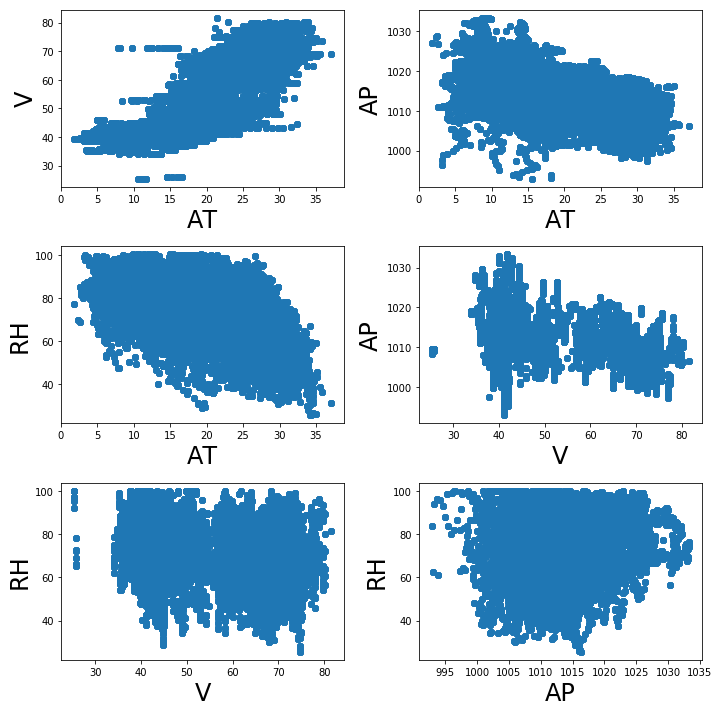

In [10]:
count = -1
for i in column_combinations:
    count += 1
    loc = (count // 2, count % 2)
    plot_element = plt.subplot2grid((3, 2), loc=loc)
    plot_element.scatter(data.loc[:,[i[0]]], data.loc[:, i[1]])
    plot_element.set_xlabel(i[0], fontsize=24)
    plot_element.set_ylabel(i[1], fontsize=24)
    plot_element.figure.set_figheight(10)
    plot_element.figure.set_figwidth(10)
    
plt.tight_layout()
plt.show()

In [11]:
import seaborn as sns

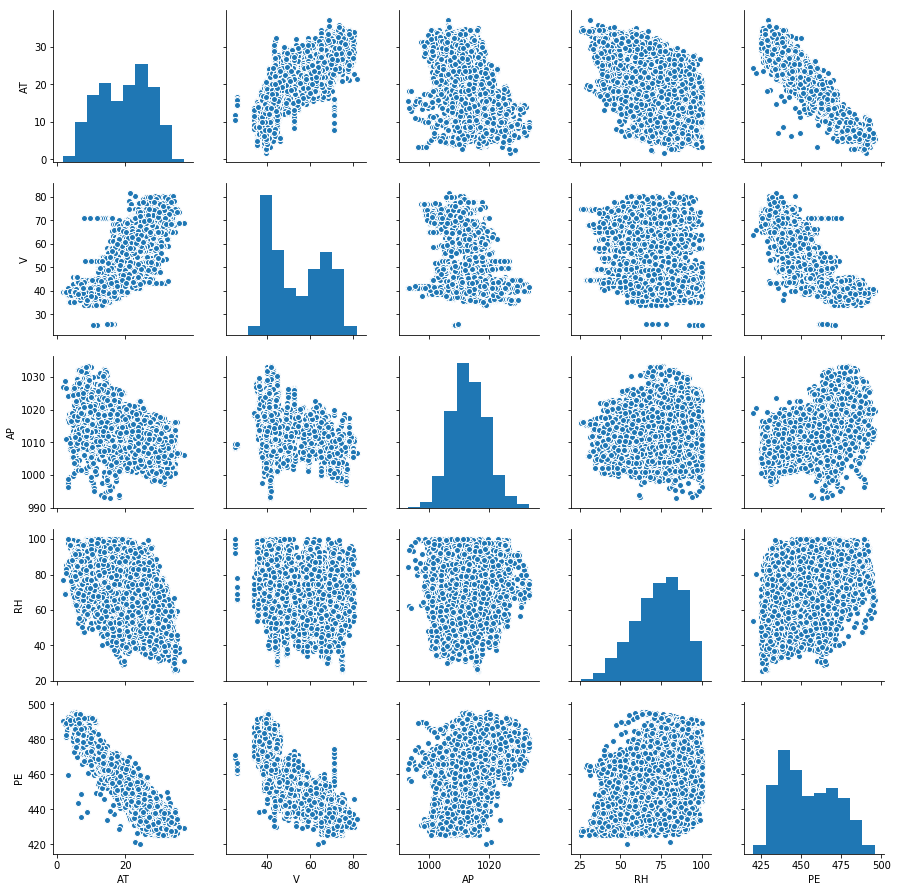

In [13]:
sns.pairplot(data=data)
plt.show()

#### iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [74]:
stats_df = tmp_data.describe()

In [75]:
data_range = stats_df.loc['max'] - stats_df.loc['min']
data_interquartile_range = stats_df.loc['75%'] - stats_df.loc['25%']
stats_df.loc['range'] = data_range
stats_df.loc['interquartile_range'] = data_interquartile_range

In [76]:
stats_df

,AT,V,AP,RH
count,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978
std,7.452162,12.707362,5.938535,14.599658
min,1.810000,25.360000,992.890000,25.560000
25%,13.510000,41.740000,1009.100000,63.327500
50%,20.345000,52.080000,1012.940000,74.975000
75%,25.720000,66.540000,1017.260000,84.830000
max,37.110000,81.560000,1033.300000,100.160000
range,35.300000,56.200000,40.410000,74.600000
interquartile_range,12.210000,24.800000,8.160000,21.502500


#### (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [77]:
from sklearn.linear_model import LinearRegression

In [78]:
from sklearn.cross_validation import train_test_split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(tmp_data, data['PE'], test_size = 0.3)

In [80]:
print(len(y_train),len(y_test))

33488 14352


In [81]:
def linear_regression_per_predictor(**kwargs):
    global count
    train_predictors = kwargs['train_predictors']
    test_predictors = kwargs['test_predictors']
    train_labels = kwargs['train_labels']
    test_labels = kwargs['test_labels']
    shape = kwargs['shape']
    count += 1
    loc = (int(count / shape[1]), count%shape[1])
    rowspan = kwargs['rowspan']
    colspan = kwargs['colspan']
    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(train_predictors, train_labels)

    # Make predictions using the testing set
    prediction = regr.predict(test_predictors)

    # The coefficients
#     print('Coefficients: \n{}'.format(regr.coef_))
    # The mean squared error
#     print("Mean squared error: {:.2f}".format(mean_squared_error(test_labels, prediction)))
    # Explained variance score: 1 is perfect prediction
#     print('Variance score: {:.2f}'.format(r2_score(test_labels, prediction)))
    
    # Plot outputs
    plot_element = plt.subplot2grid(shape = shape, loc = loc, rowspan = rowspan, colspan = colspan)
    plot_element.scatter(test_predictors, test_labels,  color='black')
    plot_element.plot(test_predictors, prediction, color='blue', linewidth=3)
    plot_element.figure.set_figheight(kwargs['figheight'])
    plot_element.figure.set_figwidth(kwargs['figwidth'])
    plot_element.axes.set_xlabel(kwargs['xlabel'], fontsize=50)
    plot_element.axes.set_ylabel(kwargs['ylabel'], fontsize=50)

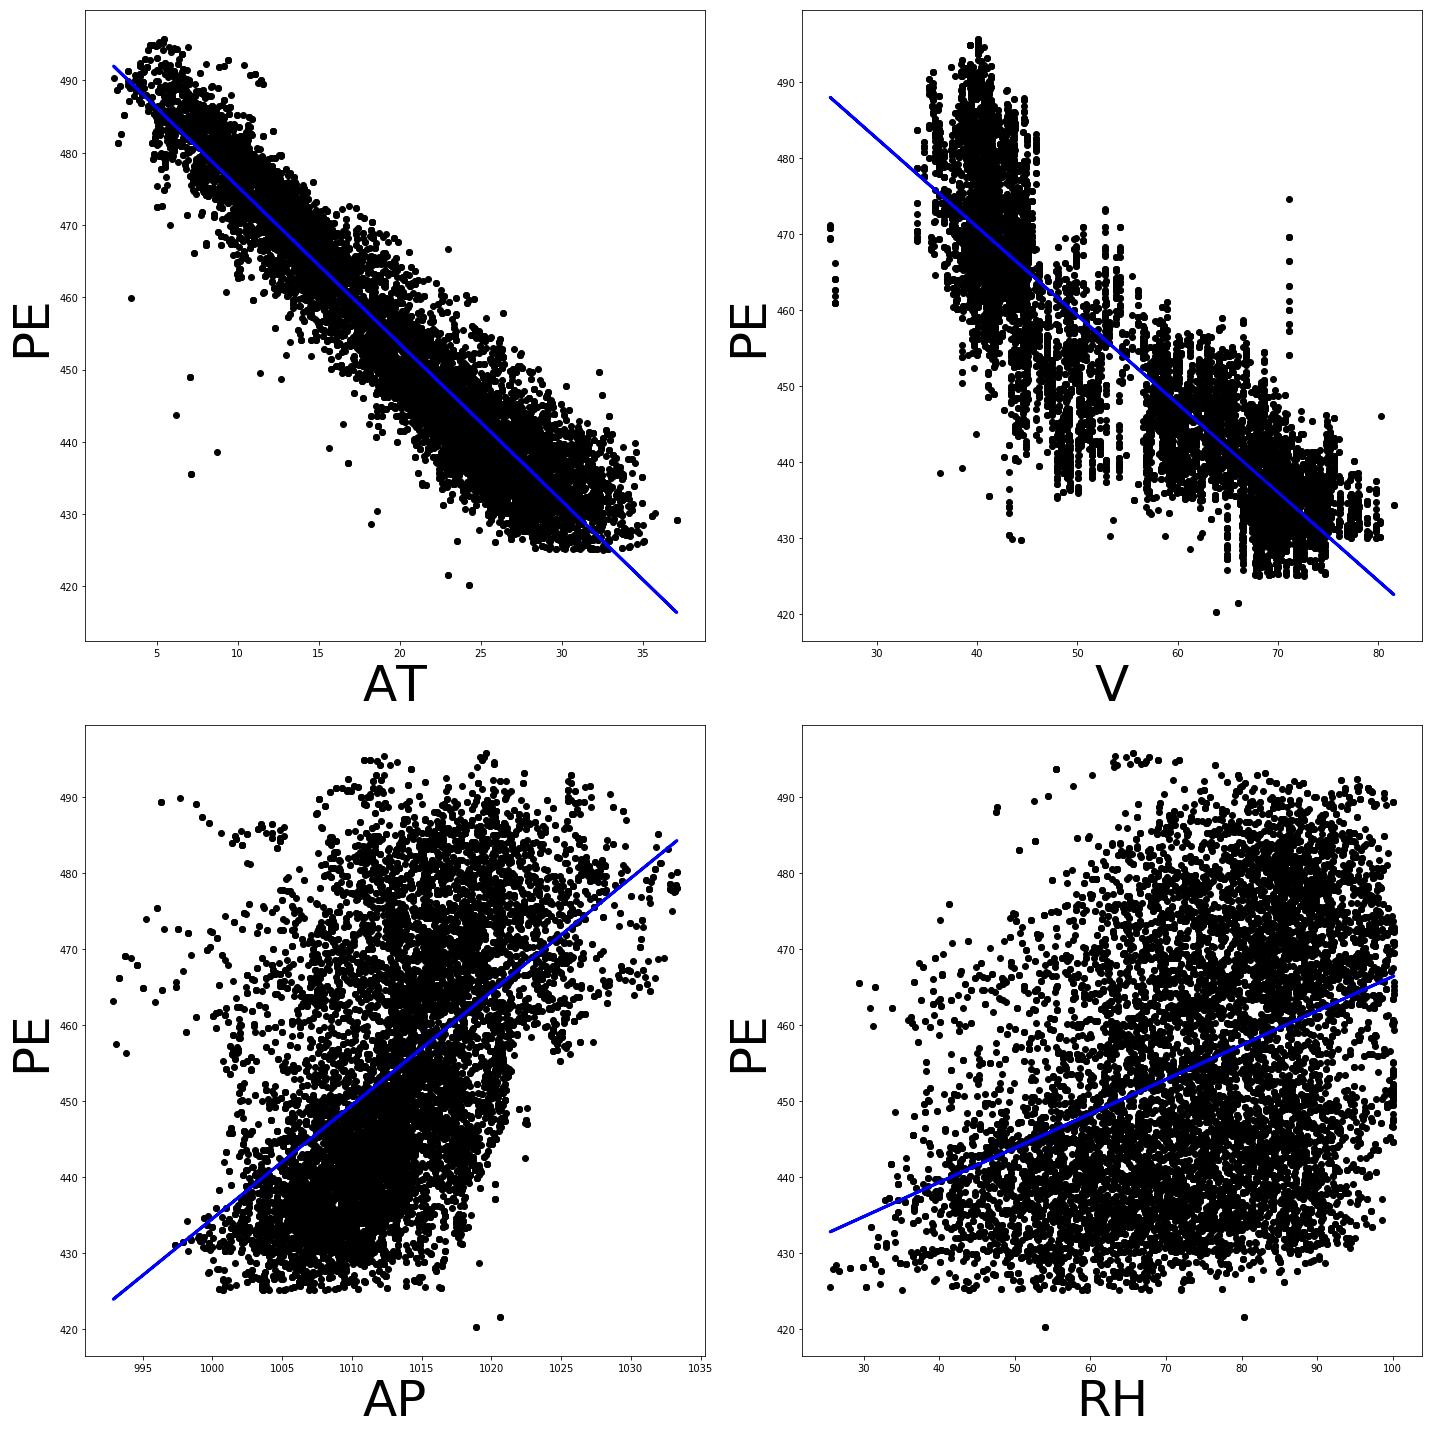

In [82]:
count = -1
for predictor in np.array(X_train.columns).tolist():
    train_predictors = np.array(X_train[predictor]).reshape(-1,1)
    test_predictors = np.array(X_test[predictor]).reshape(-1,1)
    train_labels = np.array(y_train)
    test_labels = np.array(y_test)
    linear_regression_per_predictor(train_predictors = train_predictors, train_labels = train_labels, test_predictors = test_predictors, test_labels = test_labels, shape = (2, 2), rowspan = 1, colspan = 1, xlabel = predictor, ylabel = 'PE', figheight = 20, figwidth = 20)
    plt.tight_layout()
count = -1

#### OLS Regression for predictor vs PE pair

In [83]:
significant_p_values_df = pd.DataFrame()
univariate_regression_coeffs = {}

for predictor in X_train.columns:
    print(predictor)
    model = smf.ols(formula = "PE ~ {}".format(predictor), data = pd.concat([X_train, y_train], axis=1))
    
    result = model.fit()
    
    prediction = result.predict(X_test[predictor])
    
    mse = mean_squared_error(y_test, prediction)
    
    print("Mean Squared Error = {}".format(mse))
    
    print(result.summary())
    
    univariate_regression_coeffs.update(dict(result.params))
    
    predictor_df = result.pvalues[result.pvalues <= 0.05]
    
    if 'Intercept' in list(predictor_df.index):
        predictor_df = predictor_df.drop(['Intercept'])
        
    predictor_df = pd.DataFrame(predictor_df)
    
    significant_p_values_df = pd.concat([significant_p_values_df, predictor_df])

AT
Mean Squared Error = 29.674872134016155
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 2.971e+05
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:55:38   Log-Likelihood:            -1.0409e+05
No. Observations:               33488   AIC:                         2.082e+05
Df Residuals:                   33486   BIC:                         2.082e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

In [84]:
significant_p_values_df

,0
AT,0.0
V,0.0
AP,0.0
RH,0.0


#### (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?

- Finding the p-value of all predictors
- Predictors with p-value less than 0.05 are known to successfully reject the null hypothesis

In [85]:
significant_p_values_df = pd.DataFrame()

#### Using OLS Regression for all predictors without interaction

In [86]:
data.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [87]:
model = smf.ols(formula="PE ~ AT + V + AP + RH", data = pd.concat([X_train, y_train], axis=1))
result = model.fit()
prediction = result.predict(X_test)

mse = mean_squared_error(y_test, prediction)

print("Mean squared error is {}".format(mse))

print(result.summary())

multivariate_regression_coeffs = dict(result.params)

print("\n\n Predictors with significant p-values are ")
print(result.pvalues[result.pvalues <= 0.05])

significant_p_values_df = pd.concat([significant_p_values_df, pd.DataFrame(result.pvalues[result.pvalues <= 0.05])])

Mean squared error is 20.867159771268653
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 1.086e+05
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:55:39   Log-Likelihood:                -98274.
No. Observations:               33488   AIC:                         1.966e+05
Df Residuals:                   33483   BIC:                         1.966e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

#### (e) How do your results from 2c compare to your results from 2d? Create a plot displaying the univariate regression coefficients from 2c on the x-axis, and the multiple regression coefficients from 2d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

#### Comparison of results
- R<sup>2</sup> value for simple linear regression
    - **AT** - 0.899
    - **V** - 0.756
    - **AP** - 0.270
    - **RH** - 0.154
- R<sup>2</sup> value for multiple linear regression
    - **0.928**
- This proves that multiple linear regression is a better predictor for this data than simple linear regression

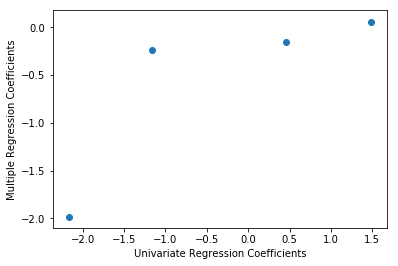

In [88]:
m_coeffs = result.params[1:]
s_coeffs = [-2.1713, -1.1656, 1.4887, 0.4579]
plt.scatter(s_coeffs, m_coeffs)
plt.xlabel("Univariate Regression Coefficients")
plt.ylabel("Multiple Regression Coefficients")
plt.show()

#### (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form Y = β0 + β1X + β2X 2 + β3X 3 + e

In [89]:
predictors = X_train.columns.tolist()
for predictor in predictors:
    form_parameters = " {} + I({} ** 2.0) + I({} ** 3.0) ".format(predictor, predictor, predictor)
    print(form_parameters)
    mod = smf.ols(formula="PE ~ {}".format(form_parameters), data = pd.concat([X_train, y_train], axis = 1))
    res = mod.fit()
    prediction = res.predict(X_test[predictor])
    mse = mean_squared_error(y_test, prediction)
    print("Mean squared error is {}".format(mse))
    print(res.summary())
    predictor_df = res.pvalues[res.pvalues <= 0.05]
    if 'Intercept' in list(predictor_df.index):
        predictor_df = predictor_df.drop(['Intercept'])
    predictor_df = pd.DataFrame(predictor_df)
    significant_p_values_df = pd.concat([significant_p_values_df, predictor_df])

 AT + I(AT ** 2.0) + I(AT ** 3.0) 
Mean squared error is 25.718600850781822
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 1.149e+05
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:55:40   Log-Likelihood:            -1.0184e+05
No. Observations:               33488   AIC:                         2.037e+05
Df Residuals:                   33484   BIC:                         2.037e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

#### Consensus
- All terms apart from V<sup>2</sup> have a p-value less than 0.05 which means that a strong non-linear association is observed between the predictors and the response variable, even in the case of **V** because V<sup>3</sup> is still significant

In [90]:
significant_p_values_df

,0
Intercept,0.000000e+00
AT,0.000000e+00
V,0.000000e+00
AP,3.122446e-32
RH,0.000000e+00
AT,2.922216e-23
I(AT ** 2.0),1.506325e-235
I(AT ** 3.0),0.000000e+00
V,6.166460e-22
I(V ** 3.0),5.144979e-03


#### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [91]:
predictors = list(itertools.combinations(X_train.columns, 2))

In [92]:
predictor_interaction_array = ['*'.join(value) for value in predictors]

In [93]:
formulae_parameters = '+'.join(predictor_interaction_array)
print(formulae_parameters)

AT*V+AT*AP+AT*RH+V*AP+V*RH+AP*RH


In [94]:
mod = smf.ols(formula="PE ~ {}".format(formulae_parameters), data = pd.concat([X_train, y_train], axis = 1))
res = mod.fit()
predict = res.predict(X_test)
mse = mean_squared_error(predict, y_test)
print("Mean squared error is {}".format(mse))
print(res.summary())
predictor_df = res.pvalues[res.pvalues <= 0.05]
if 'Intercept' in list(predictor_df.index):
    predictor_df = predictor_df.drop(['Intercept'])
predictor_df = pd.DataFrame(predictor_df)
significant_p_values_df = pd.concat([significant_p_values_df, predictor_df])

Mean squared error is 18.608204173249053
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 4.897e+04
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:55:44   Log-Likelihood:                -96398.
No. Observations:               33488   AIC:                         1.928e+05
Df Residuals:                   33477   BIC:                         1.929e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

#### Consensus
- **AT:AP** is the only variable which has a p-value greater than 0.05, hence we reject it

In [95]:
significant_p_values_df

,0
Intercept,0.000000e+00
AT,0.000000e+00
V,0.000000e+00
AP,3.122446e-32
RH,0.000000e+00
AT,2.922216e-23
I(AT ** 2.0),1.506325e-235
I(AT ** 3.0),0.000000e+00
V,6.166460e-22
I(V ** 3.0),5.144979e-03


#### (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [96]:
list(set(list(significant_p_values_df.index)))

['RH',
 'I(V ** 3.0)',
 'I(AT ** 2.0)',
 'AT:V',
 'I(AP ** 2.0)',
 'AP',
 'Intercept',
 'AP:RH',
 'I(AP ** 3.0)',
 'I(RH ** 2.0)',
 'I(RH ** 3.0)',
 'AT:RH',
 'V:AP',
 'AT',
 'V',
 'I(AT ** 3.0)',
 'V:RH']

In [97]:
new_preds = [pred.replace("I(", "").replace(")","").replace(':',' * ').replace("[T.", "_").strip("]").replace("]", "").split() for pred in list(set(list(significant_p_values_df.index)))]

In [98]:
new_preds.remove(['Intercept'])

In [99]:
new_preds

[['RH'],
 ['V', '**', '3.0'],
 ['AT', '**', '2.0'],
 ['AT', '*', 'V'],
 ['AP', '**', '2.0'],
 ['AP'],
 ['AP', '*', 'RH'],
 ['AP', '**', '3.0'],
 ['RH', '**', '2.0'],
 ['RH', '**', '3.0'],
 ['AT', '*', 'RH'],
 ['V', '*', 'AP'],
 ['AT'],
 ['V'],
 ['AT', '**', '3.0'],
 ['V', '*', 'RH']]

In [100]:
final_predictor.sample()

,PE
10989,434.25


In [101]:
final_predictor = pd.DataFrame()
for predictor in new_preds:
    if len(predictor) == 1:
        final_predictor = pd.concat([final_predictor, pd.DataFrame(np.expand_dims(data[predictor[0]], axis=1), columns=["{}".format(predictor[0])])], axis = 1)
    elif len(predictor) == 3:
        if predictor[1] == "**":
            final_predictor = pd.concat([final_predictor, pd.DataFrame(np.power(np.array(data[predictor[0]]), float(predictor[2])), columns = ["{}RAISEDTO{}".format(predictor[0], int(float(predictor[2])))])], axis = 1)
        elif predictor[1] == "*":
            final_predictor = pd.concat([final_predictor, pd.DataFrame(np.array(data[predictor[0]] * data[predictor[2]]), columns = ["{}INTO{}".format(predictor[0], predictor[2])])], axis = 1)

In [102]:
final_predictor = pd.concat([final_predictor, pd.DataFrame(np.expand_dims(data['PE'], axis=1), columns=['PE'])], axis=1)

In [103]:
final_predictor.sample(5)

,RH,VRAISEDTO3,ATRAISEDTO2,ATINTOV,APRAISEDTO2,AP,APINTORH,APRAISEDTO3,RHRAISEDTO2,RHRAISEDTO3,ATINTORH,VINTOAP,AT,V,ATRAISEDTO3,VINTORH,PE
16547,83.08,251120.161629,346.3321,1174.1049,1.039115e+06,1019.37,84689.2596,1.059243e+09,6902.2864,573441.954112,1546.1188,64312.0533,18.61,63.09,6445.240381,5241.5172,449.81
21480,77.63,432081.216000,646.1764,1921.7520,1.035082e+06,1017.39,78979.9857,1.053082e+09,6026.4169,467830.743947,1973.3546,76914.6840,25.42,75.60,16425.804088,5868.8280,438.24
6532,63.38,323818.116363,859.0761,2012.7177,1.012398e+06,1006.18,63771.6884,1.018655e+09,4017.0244,254599.006472,1857.6678,69094.3806,29.31,68.67,25179.520491,4352.3046,435.57
28868,88.37,72095.179528,151.7824,512.7584,1.024468e+06,1012.16,89444.5792,1.036925e+09,7809.2569,690104.032253,1088.7184,42126.0992,12.32,41.62,1869.959168,3677.9594,455.71
46467,70.28,236717.162856,730.0804,1671.4572,1.024913e+06,1012.38,71150.0664,1.037602e+09,4939.2784,347132.485952,1898.9656,62625.8268,27.02,61.86,19726.772408,4347.5208,442.67


In [104]:
X_train = final_predictor.drop(['PE'], axis = 1).iloc[X_train.index]
y_train = final_predictor['PE'].iloc[y_train.index]
X_test = final_predictor.drop(['PE'], axis = 1).iloc[X_test.index]
y_test = final_predictor['PE'].iloc[y_test.index]

In [105]:
formulae_parameters = "+".join(list(X_train.columns))

In [106]:
mod = smf.ols(formula="PE ~ {}".format(formulae_parameters), data = pd.concat([X_train, y_train], axis = 1))
res = mod.fit()
predict = res.predict(X_test)
mse = mean_squared_error(predict, y_test)
print("Mean squared error is {}".format(mse))
print(res.summary())
predictor_df = res.pvalues[res.pvalues <= 0.05]
if 'Intercept' in list(predictor_df.index):
    predictor_df = predictor_df.drop(['Intercept'])
predictor_df = pd.DataFrame(predictor_df)
significant_p_values_df = pd.concat([significant_p_values_df, predictor_df])

Mean squared error is 17.5707174208863
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 3.356e+04
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:55:58   Log-Likelihood:                -95983.
No. Observations:               33488   AIC:                         1.920e+05
Df Residuals:                   33472   BIC:                         1.921e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept  

#### Observation
- In the above model we notice that V<sup>3</sup>, RH<sup>3</sup> and V*RH have a p-value >= 0.05. Eliminating them we can expect the model to perform better, doing just that !!

In [109]:
formulae_parameters = formulae_parameters.replace("+VRAISEDTO3", "")
formulae_parameters = formulae_parameters.replace("+RHRAISEDTO3", "")
formulae_parameters = formulae_parameters.replace("VINTORH", "")
formulae_parameters = formulae_parameters.strip("+")
formulae_parameters

'RH+ATRAISEDTO2+ATINTOV+APRAISEDTO2+AP+APINTORH+APRAISEDTO3+RHRAISEDTO2+ATINTORH+VINTOAP+AT+V+ATRAISEDTO3'

In [110]:
mod = smf.ols(formula="PE ~ {}".format(formulae_parameters), data = pd.concat([X_train, y_train], axis = 1))
res = mod.fit()
predict = res.predict(X_test)
mse = mean_squared_error(predict, y_test)
print("Mean squared error is {}".format(mse))
print(res.summary())
predictor_df = res.pvalues[res.pvalues <= 0.05]
if 'Intercept' in list(predictor_df.index):
    predictor_df = predictor_df.drop(['Intercept'])
predictor_df = pd.DataFrame(predictor_df)
significant_p_values_df = pd.concat([significant_p_values_df, predictor_df])

Mean squared error is 17.566146799696014
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 4.195e+04
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:57:50   Log-Likelihood:                -95985.
No. Observations:               33488   AIC:                         1.920e+05
Df Residuals:                   33475   BIC:                         1.921e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept

- Best Test Error using possible interaction terms and non-linear associations = **17.566**
- Best Train Error using only interaction terms = **20.867**
- This is the least test error we have obtained amongst all models we trained which proves that we indeed can improve our model by using possible interaction terms and non-linear associations

#### (i) KNN Regression:
#### i. Perform k-nearest neighbor regression for this dataset. Find the value of k ∈ {1, 2, . . . , 100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

In [111]:
columns = tmp_data.columns

In [112]:
import sys

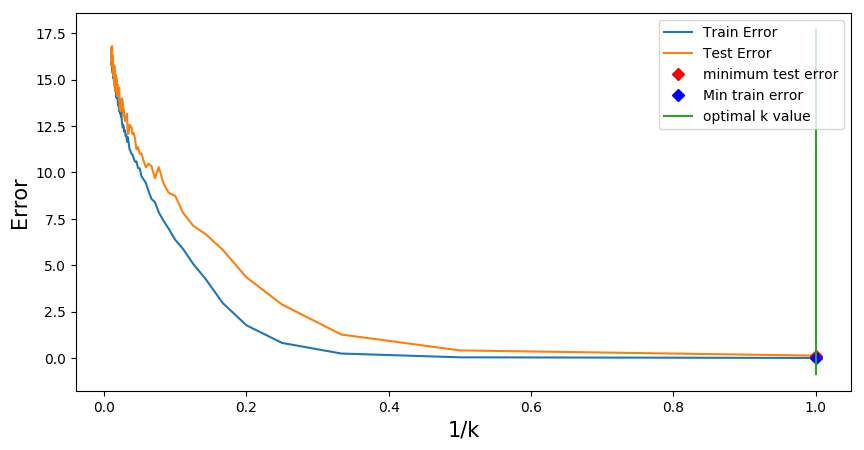

Min test error 0.1257100404124863 for k value 1
Min train error 0.0 for k value 1
Optimal k value 1


In [113]:
first_inflection_point_reached = False
prev_error_diff = sys.maxsize
one_by_k_array = []
test_error_array = []
train_error_array = []
min_test_error = sys.maxsize
min_train_error = sys.maxsize

for k in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data['PE'], test_size = 0.3)
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    y_ = pd.Series(knn.fit(X_train, y_train).predict(X_test))
    test_error = mean_squared_error(y_test, y_)
    min_test_error = min_test_error if min_test_error < test_error else test_error
    test_error_array.append(test_error)
    one_by_k_array.append(1/k)
    y_ = pd.Series(knn.fit(X_train, y_train).predict(X_train))
    train_error = mean_squared_error(y_train, y_)
    train_error_array.append(train_error)
    min_train_error = min_train_error if min_train_error < train_error else train_error
    if first_inflection_point_reached == False:
        if prev_error_diff > (test_error - train_error):
            prev_error_diff = test_error - train_error
        else:
            first_inflection_point_reached = True
            prev_error_diff = k - 1
    
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(one_by_k_array, train_error_array)
plt.plot(one_by_k_array, test_error_array)
plt.plot(one_by_k_array[test_error_array.index(min_test_error)], test_error_array[test_error_array.index(min_test_error)], 'rD')
plt.plot(one_by_k_array[train_error_array.index(min_train_error)], train_error_array[train_error_array.index(min_train_error)], 'bD')
plt.xlabel("1/k", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
ylimit = plt.ylim()
plt.plot([1/prev_error_diff, 1/prev_error_diff], list(ylimit))
plt.legend(["Train Error", "Test Error", "minimum test error","Min train error", "optimal k value"], loc = 'upper right')
plt.show()
print("Min test error {} for k value {}".format(min_test_error, int(1/one_by_k_array[test_error_array.index(min_test_error)])))
print("Min train error {} for k value {}".format(min_train_error, int(1/one_by_k_array[train_error_array.index(min_train_error)])))
print("Optimal k value {}".format(prev_error_diff))

### Splitting the dataset into test and train set

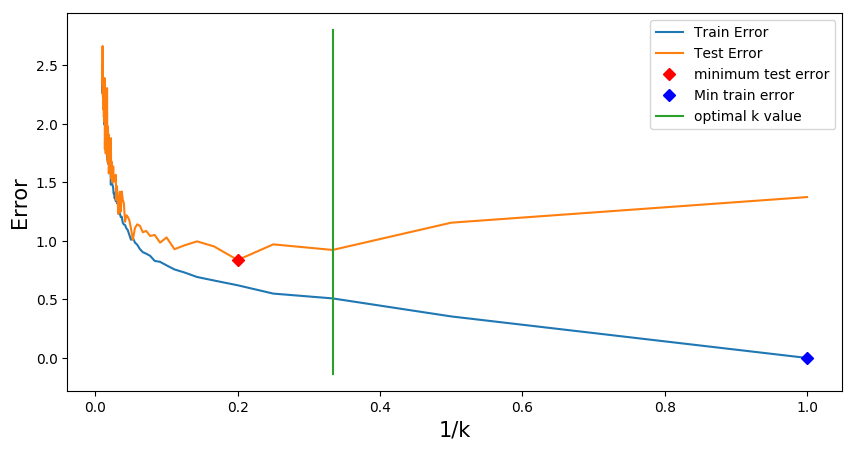

Min test error 0.836965178683384 for k value 5
Min train error 0.0 for k value 1
Optimal k value 3


In [124]:
first_inflection_point_reached = False
prev_error_diff = sys.maxsize
one_by_k_array = []
test_error_array = []
train_error_array = []
min_test_error = sys.maxsize
min_train_error = sys.maxsize

for k in range(1,101):
    X_train, X_test, y_train, y_test = train_test_split(sheet1, sheet1['PE'], test_size = 0.3)
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    y_ = pd.Series(knn.fit(X_train, y_train).predict(X_test))
    test_error = mean_squared_error(y_test, y_)
#     test_error = np.mean((y_test - y_)**2)
    min_test_error = min_test_error if min_test_error < test_error else test_error
    test_error_array.append(test_error)
    one_by_k_array.append(1/k)
    y_ = pd.Series(knn.fit(X_train, y_train).predict(X_train))
    train_error = mean_squared_error(y_train, y_)
#     train_error = np.mean((y_train - y_)**2)
    train_error_array.append(train_error)
    min_train_error = min_train_error if min_train_error < train_error else train_error
    if first_inflection_point_reached == False:
        if prev_error_diff > (test_error - train_error):
            prev_error_diff = test_error - train_error
        else:
            first_inflection_point_reached = True
            prev_error_diff = k - 1
    
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(one_by_k_array, train_error_array)
plt.plot(one_by_k_array, test_error_array)
plt.plot(one_by_k_array[test_error_array.index(min_test_error)], test_error_array[test_error_array.index(min_test_error)], 'rD')
plt.plot(one_by_k_array[train_error_array.index(min_train_error)], train_error_array[train_error_array.index(min_train_error)], 'bD')
plt.xlabel("1/k", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
ylimit = plt.ylim()
plt.plot([1/prev_error_diff, 1/prev_error_diff], list(ylimit))
plt.legend(["Train Error", "Test Error", "minimum test error","Min train error", "optimal k value"], loc = 'upper right')
plt.show()
print("Min test error {} for k value {}".format(min_test_error, int(1/one_by_k_array[test_error_array.index(min_test_error)])))
print("Min train error {} for k value {}".format(min_train_error, int(1/one_by_k_array[train_error_array.index(min_train_error)])))
print("Optimal k value {}".format(prev_error_diff))

#### (j) Compare the results of KNN Regression with linear regression and provide your analysis.

- KNN seems to have drastically better test errors (MSE) compared to Linear Regression
- KNN tends to fit data better is more flexible than Linear regression which justifies the drastic increase we see in its performance.